# Segmentation
Imports and define names of datafiles

In [1]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
import matplotlib.pyplot as plt
from tqdm import tqdm  
from typing import List,Tuple
import torch.nn as nn
import numpy as np
import regex as re
import random
import json
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
datafiles= {
  "E1" : [''],
  "E2" : ['a', 'b'],
  "E3" : [''],
  "E4" : ['']
}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Function that extracts headwords out of \<b\> tags to build a headword dataset.

In [2]:
def build_b_tag_dataset(datastring, next_chars = 500, verbose=False):
  b_tag_dict = []

  # BUILD POSITIVE 
  for match in tqdm(re.finditer(r"((?<=<b>).+<\/b>)(.*(?<=<b>).+<\/b>)*", datastring), disable=(not verbose)):
    g1 = match.group(0)
    matched_b_tag = re.sub(r"</b>.*<b>|</b>"," ",g1).strip()
    end_of_b_tag = match.end()  
    
    surrounding_text_match = re.search(r"([^<]{1,"+str(next_chars)+r"})(?=<|$)", datastring[end_of_b_tag:end_of_b_tag+next_chars])
    surrounding_text = surrounding_text_match.group(0) if surrounding_text_match else ""

    short_def = re.sub(r"\s+", " ", surrounding_text).strip()
    if len(short_def) > 0:
      b_tag_dict.append([f"{matched_b_tag} {short_def}", matched_b_tag])

  # BUILD NEGATIVE
  for match in tqdm(re.finditer(r"(\n\n\p{Upper}[^<]{10,500})(?=\n|$|<)", datastring), disable=(not verbose)):
    g = match.group(0)
    matched_text = re.sub(r"\s+", " ", g).strip()
    b_tag_dict.append([matched_text, ""])

  return b_tag_dict

Build the headword datasets for the first and second editions (E1 \& E2) where for each entry there is:
  - Feature: A paragraph or piece of text that starts with a headword, followed by up to <i>next_chars</i> number of characters, default is 500.
  - label: The headword at the beginning of the corresponding feature, empty string if feature wasn't a <i>"headword"</i> paragraph.

Save results to json files:
```json
  ["Lund, uppstad i Malmöhus län...beskaffenhet. I all", "Lund,"]
  ["betjenade sig af rapporter från...till privatlifvet", ""]
```

In [3]:
def build_json_headword_set():
  for edition in ['E1', 'E2']:

    dataset = ""
    for file in datafiles.get(edition):
      with open(f"./dataset/NF_{edition}{file}.txt", "r", encoding='utf-8') as fr:
        dataset += fr.read()
        fr.close()
        
    b_tag_dict = build_b_tag_dataset(dataset, verbose=True)
    print(f"{edition} has {len(b_tag_dict):,} entries")

    with open(f"./dataset/NF_{edition}_B.json", "w") as b_json:
      json.dump(b_tag_dict, b_json, indent=2, ensure_ascii=False)
  del edition, dataset, file, fr, b_tag_dict, b_json
# build_json_headword_set()

In [4]:
tokenizer = AutoTokenizer.from_pretrained("KB/bert-base-swedish-cased")
BUILD_HEADWORD = False

def process_data(sentence, headword):
    encoded_sentence = tokenizer(
        sentence,
        add_special_tokens=True, 
        padding='max_length',   
        max_length=100,        
        truncation=True,       
        return_tensors='pt'  
    )
    encoded_headword = tokenizer(
        headword,
        add_special_tokens=True,
        padding='max_length',
        max_length=20,           
        truncation=True,
        return_tensors='pt'
    )
    return encoded_sentence['input_ids'][0], encoded_headword['input_ids'][0]

def extract_features_labels(dataset) -> Tuple[List, List]:
    x = []
    y = []
    for entry in tqdm(dataset):
      sentence, headword = process_data(entry[0], entry[1])
      x.append(sentence)

      min_len = min(len(sentence), len(headword))
      headword_mask = np.where((sentence[:min_len] > 4) & (sentence[:min_len] == headword[:min_len]), 1, 0)
      headword_mask = np.pad(headword_mask, (0, len(sentence) - min_len), 'constant')
      
      y.append(torch.tensor(headword_mask))
    return torch.stack(x).to(device), torch.stack(y).to(device)

def build_headword_dataset():
  def load_headword_json():
    out = []
    for edition in ['E1', 'E2']:
        with open(f"./dataset/NF_{edition}_B.json", "r", encoding='utf-8') as b_json:
          out += json.load(b_json)
          b_json.close()
    return out
  dataset = load_headword_json()
  random.seed(123)
  random.shuffle(dataset)
  dataset = dataset[5000:]
  temp_X, temp_y = extract_features_labels(dataset)
  torch.save((temp_X,temp_y),'./dataset/headword_dataset.pth')
  return temp_X, temp_y

# Load in manually annotated test set. 
with open("./dataset/NF_test_set_12_annotated.json", "r", encoding='utf-8') as annotated_test:
  test_set = json.load(annotated_test)
  annotated_test.close()
X_test, y_test = extract_features_labels(test_set) # <-- Use this to comapre different models. 

# Either build pytorch dataset out of json, or load in saved pth file.
if BUILD_HEADWORD:
  X, y = build_headword_dataset()            
else:
  X, y = torch.load('./dataset/headword_dataset.pth', weights_only=True)
X.shape, y.shape # <-- Use this to train our model or fine-tune a model.  

100%|██████████| 5000/5000 [00:03<00:00, 1515.16it/s]


(torch.Size([303448, 100]), torch.Size([303448, 100]))

In [5]:
example_index = 1
input = X[example_index]
mask = y[example_index]
headword = X[example_index][torch.flatten(torch.nonzero(y[example_index]))]
print(f"Input Sentence: \n{tokenizer.decode(input, skip_special_tokens=True)}\n")
print(f"Tokenized Sentence: \n{input.tolist()}\n")
print(f"Target Mask: \n{mask.tolist()}\n")
print(f"Target Headword: \n{tokenizer.decode(headword, skip_special_tokens=True)}")

Input Sentence: 
Bondesen, Ingvor, dansk författare, f. 1844, var 186485 skollärare på Fyn, blef därefter anställd i Köpenhamns skolväsen och 1892 skolinspektör vid en af skolorna därstädes. Han började 1877 under märket Henning Fox att skrifva historiska romaner från den äldre medeltiden, Styrismanden og hans brud ( 1877 ) och Kongsbrydens fostersön ( 1878 ). Senare följde berättelser med ämnen från adelsväldets tid, Rettergang og skriftegang

Tokenized Sentence: 
[2, 17431, 436, 19, 1613, 8143, 19, 5908, 4567, 19, 13, 7, 21978, 49841, 19, 96, 42581, 5727, 16964, 4759, 68, 48349, 19, 21829, 49808, 3386, 7410, 31, 32754, 1005, 28343, 36, 35907, 1005, 17969, 252, 59, 4815, 13349, 256, 23055, 7, 371, 1649, 42456, 244, 19997, 15860, 13469, 48, 1147, 49808, 384, 8521, 15797, 146, 97, 2332, 21045, 19, 15307, 2894, 963, 5196, 699, 14503, 177, 42456, 171, 36, 7954, 9213, 389, 148, 11989, 21345, 177, 40999, 171, 7, 9475, 5622, 12631, 66, 7114, 146, 23410, 746, 1730, 353, 290, 19, 17187, 95, 19

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20) # <-- Use to train our model or fine-tune a model.
print("Vocab size:", tokenizer.vocab_size)
print("Max input ID:", torch.max(X_train).item())

Vocab size: 50325
Max input ID: 49968


In [7]:
class HeadwordExtractor():
  def __init__(self, saved_model):
    self.embedding_dim = 128
    self.hidden_dim = 128
    self.batch_size = 32
    self.num_epochs = 5
    self.learning_rate = 0.001
    self.saved_model = saved_model
    
    self.train_loader = DataLoader(TensorDataset(X_train.long(), y_train.long()), batch_size=self.batch_size, shuffle=True)
    self.val_loader = DataLoader(TensorDataset(X_val.long(), y_val.long()), batch_size=self.batch_size, shuffle=False)

    self.model = self.EncoderLSTM(tokenizer.vocab_size, self.embedding_dim, self.hidden_dim, nbr_classes=2, num_layers=1,bidi_lstm=True).to(device)

    self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
    self.criterion = nn.CrossEntropyLoss()
    print(self.model)

  class EncoderLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, nbr_classes, num_layers=1, bidi_lstm=False):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=tokenizer.pad_token_id)
        self.encoder = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=bidi_lstm)
        if not bidi_lstm:
            self.fc = nn.Linear(hidden_dim, nbr_classes)
        else:
            self.fc = nn.Linear(2*hidden_dim, nbr_classes)

    def forward(self, sentence):
        embeds = self.embeddings(sentence)
        encoder_out, _ = self.encoder(embeds)
        encoder_out = nn.functional.relu(encoder_out)
        logits = self.fc(encoder_out)
        return logits

  def train_extractor(self):
    history=[]
    for epoch in range(self.num_epochs):
        print(f"Epoch {epoch+1}/{self.num_epochs}:")
      
        self.model.train()
        train_loss = 0
        train_accuracy = 0
        temp = 0
        for input_batch, target_batch in tqdm(self.train_loader, desc = "Training"):
            outputs = self.model(input_batch)

            loss = self.criterion(outputs.view(-1,outputs.shape[-1]), target_batch.view(-1))
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            train_loss += loss.item()
            train_accuracy += (torch.sum(outputs.view(-1,outputs.shape[-1]).argmax(dim=1) == target_batch.view(-1))/target_batch.view(-1).shape[0]).item()
        avg_train_loss = train_loss / len(self.train_loader)
        avg_train_acc = train_accuracy / len(self.train_loader)
        print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_acc:.4f}")

        self.model.eval()
        with torch.no_grad():
            val_loss = 0
            val_accuracy = 0
            for input_batch, target_batch in tqdm(self.val_loader, desc = "Validation"):
              outputs = self.model(input_batch)

              loss = self.criterion(outputs.view(-1,outputs.shape[-1]), target_batch.view(-1))
              val_loss += loss.item()
              val_accuracy += (torch.sum(outputs.view(-1,outputs.shape[-1]).argmax(dim=1) == target_batch.view(-1))/target_batch.view(-1).shape[0]).item()
        avg_val_loss = val_loss/len(self.val_loader)
        avg_val_acc = val_accuracy / len(self.val_loader)
        print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {avg_val_acc:.4f}\n")

        history.append((avg_train_loss, avg_train_acc, avg_val_loss, avg_val_acc))
    self.__plot_metrics(history)

  def __plot_metrics(self, history):
    train_loss, train_acc, val_loss, val_acc = tuple(zip(*history))
    epochs = range(1, len(history) + 1)

    plt.figure(figsize=(12, 6))
    plt.subplot(1,2,1)
    plt.plot(epochs, train_acc, marker='o', linestyle='-', label='Train Accuracy')
    plt.plot(epochs, val_acc, marker='o', linestyle='-', label='Validation Accuracy')
    plt.title('Validation vs Train Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, train_loss, marker='o', linestyle='-', label='Train Loss')
    plt.plot(epochs, val_loss, marker='o', linestyle='-', label='Validation Loss')
    plt.title('Validation vs Train Loss')
    plt.legend()
    plt.show()

  def predict(self, encoded_input):
    self.model.eval()
    with torch.no_grad():
      output_mask = self.model(encoded_input).argmax(dim=-1).cpu()
      
    for entry_index, token_index in enumerate(output_mask.argmax(1)):
      while_index = token_index
      while output_mask[entry_index, while_index] == 1 and while_index > 0 and tokenizer.decode(encoded_input[entry_index, while_index]).startswith("##"):
        output_mask[entry_index, while_index-1] = 1
        while_index-=1

    return output_mask
  
  def load_model(self):
     self.model.load_state_dict(torch.load(self.saved_model, weights_only=True))
     self.model.eval()
  
  def save_model(self):
     torch.save(self.model.state_dict(), self.saved_model)

Train or load model from saved file. 

In [8]:
SAVED_MODEL = "headword_extractor.pth"
TRAIN_NEW_MODEL = False

extractor = HeadwordExtractor(saved_model=SAVED_MODEL)

if TRAIN_NEW_MODEL:
  extractor.train_extractor()
  extractor.save_model()
else:
  extractor.load_model()

EncoderLSTM(
  (embeddings): Embedding(50325, 128, padding_idx=0)
  (encoder): LSTM(128, 128, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)


Evaluation on test set.

Test Accuracy: 99.63%
Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    484419
           1       0.96      0.92      0.94     15581

    accuracy                           1.00    500000
   macro avg       0.98      0.96      0.97    500000
weighted avg       1.00      1.00      1.00    500000

Confusion Matrix:


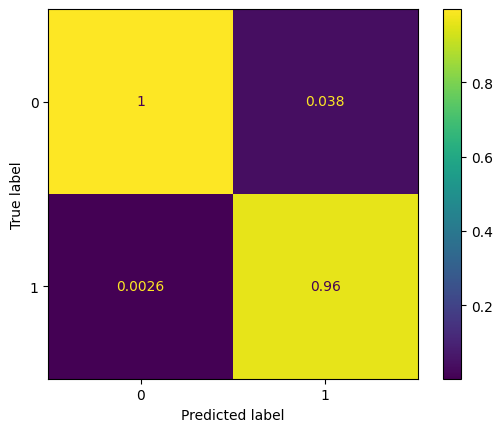

In [9]:
y_test_predictions = extractor.predict(X_test).view(-1)
y_test = y_test.view(-1).cpu()

print(f"Test Accuracy: {(accuracy_score(y_test, y_test_predictions)*100):.2f}%")
print(f"Classification Report: \n{classification_report(y_test, y_test_predictions)}")
cm = confusion_matrix(y_test, y_test_predictions, normalize='pred')
cmd = ConfusionMatrixDisplay(cm, display_labels=[0,1])
cmd.plot()
print("Confusion Matrix:")

In [10]:
input_sentence = "Gustav Vasa, ursprungligen Gustav Eriksson,[2] enligt flera källor född 12 maj 1496, död 29 september 1560 på Tre Kronor i Stockholm.[3] var kung av Sverige 1523–1560 och riksföreståndare 1521–1523, under det pågående befrielsekriget. Hans makttillträde, inlett som ett uppror mot unionskungen Kristian II efter Stockholms blodbad, innebar slutet för"
encoded_input = tokenizer(input_sentence, return_tensors="pt", padding = "max_length", max_length = 100, truncation = True)['input_ids'].to(device)

output_mask = extractor.predict(encoded_input).view(-1)
headword = encoded_input.cpu().view(-1)[torch.flatten(torch.nonzero(output_mask))]
print("Predicted headword:", tokenizer.decode(headword, skip_special_tokens=True))

Predicted headword: Gustav Vasa,


In [11]:
def tokenize_editions():
  tokenized_editions = []
  for edition in datafiles.keys():
    edition_data = ""
    for file in datafiles.get(edition):
      with open(f"./dataset/NF_{edition}{file}.txt", "r", encoding='utf-8') as fr:
        edition_data += fr.read()
        fr.close()
    edition_data = re.sub(r"<b>|</b>", "", edition_data)
    
    splitted_paragraphs = re.split(r"\n\n", edition_data)
    filterd_paragraphs = filter(lambda p: len(p) >= 10, splitted_paragraphs)
    truncated_paragraphs = map(lambda p: p[:500] if len(p) > 500 else p, filterd_paragraphs)
    
    paragraphs = torch.stack(
      [tokenizer(
          p,
          add_special_tokens=True, 
          padding='max_length',   
          max_length=100,        
          truncation=True,       
          return_tensors='pt'  
        )['input_ids'][0] 
        for p in tqdm(list(truncated_paragraphs))
      ]).to(device)
    tokenized_editions.append(paragraphs)
  torch.save(tokenized_editions, './dataset/tokenized_editions.pth')
  return tokenized_editions

SHOULD_TOKENIZE_EDITIONS = False
if SHOULD_TOKENIZE_EDITIONS:
  editions = tokenize_editions()
else:
  editions = torch.load('./dataset/tokenized_editions.pth', weights_only=True)

In [ ]:
def predict_editions():
  db = {}
  for ei, edition in enumerate(editions):
    # Predict editions by batches:
    edition_loader = DataLoader(edition, batch_size=19000, shuffle=False)
    edition_predictions = torch.empty((0,100)).to(device)
    for batch in tqdm(edition_loader, desc=f"Predicting Edtion E{ei+1}"):
      batch_prediction = extractor.predict(batch).to(device)
      edition_predictions = torch.cat((edition_predictions, batch_prediction))

    # Filter away non-headword predictions:
    predicted_input = edition[torch.unique(torch.nonzero(edition_predictions)[:, 0])]
    predicted_masks = edition_predictions[torch.unique(torch.nonzero(edition_predictions)[:, 0])]
    predicted_entires = []
    entry_cnt = 0
    for input, mask in tqdm(list(zip(predicted_input,predicted_masks)), desc=f"Decoding   Edtion E{ei+1}"):
      decoded_headword = tokenizer.decode(input[mask.nonzero().flatten()], skip_special_tokens=True)
      decoded_headword = re.sub(r",", "", decoded_headword)
      if decoded_headword != "":
        decoded_input = tokenizer.decode(input, skip_special_tokens=True)

        if not re.search(r"^Bild [\diI]+", decoded_input):
          entry_cnt+=1
          predicted_entires.append({"entry_id": f"E{ei+1}_{entry_cnt}", "headword": decoded_headword, "definition": decoded_input})
          
    db[f"E{ei+1}"] = predicted_entires

  with open("./extracted_entries.json", "w") as entry_json:
    json.dump(db, entry_json, indent=2, ensure_ascii=False)
    entry_json.close()

def load_in_db():
  try:
    with open("./extracted_entries.json", "r", encoding='utf-8') as entry_json_r:
      db = json.load(entry_json_r)
      entry_json_r.close()
  except:
    db = {}
  return db

# predict_editions()
db = load_in_db()
len(db['E1']), len(db['E2']), len(db['E3']), len(db['E4'])

(117629, 178449, 25005, 84167)

In [19]:
ner_model = AutoModelForTokenClassification.from_pretrained("KB/bert-base-swedish-cased-ner").to(device)

def classify_entity(sentence, headword):
  """
  Returns
    0 --> Other\n
    1 --> Location\n
    2 --> Person
  """
  encoded_sentence = tokenizer(sentence,add_special_tokens=True,padding='max_length',max_length=100,truncation=True,return_tensors='pt').to(device)
  encoded_headword = tokenizer(headword,add_special_tokens=True,padding='max_length',max_length=20,truncation=True,return_tensors='pt')['input_ids'][0]

  with torch.no_grad():
    encoded_outputs = torch.argmax(ner_model(**encoded_sentence).logits, dim=2)

  labels = encoded_outputs.flatten()[(encoded_headword > 4).nonzero()].flatten()
  if 7 in labels and 9 in labels:
    return 0
  elif 7 in labels:
    return 1
  elif 9 in labels:
    return 2
  else:
    return 0

for e in db:
  entries = db[e]

  for entry in tqdm(entries[:10]):
    ner = classify_entity(entry['definition'], entry['headword'])
    entry['type'] = ner
  
with open("./ner_entires.json", "w") as ner_json:
  json.dump(db, ner_json, indent=2, ensure_ascii=False)
  ner_json.close()

Some weights of the model checkpoint at KB/bert-base-swedish-cased-ner were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 10/10 [00:00<00:00, 71.94it/s]
